In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import time

In [2]:
if not (os.path.isfile("df_features_bow_sampled.parquet") and os.path.isfile("df_features_tfidf_sampled.parquet")):
    raise Exception("You should run the section 1 before")
df_features_bow_sampled = pd.read_parquet("df_features_bow_sampled.parquet")
df_features_tfidf_sampled = pd.read_parquet("df_features_tfidf_sampled.parquet")

<br>
<left><b><font size=4>Section 2 – Supervised Learning – Classification<b><left>

<br>
<div style="text-align: justify"> Classify the tactics of an attack session, based on the used words in the text and also possibly on time. Notice that each session have multiple labels. Hence you can decompose the problem into multiple binary classification problems. For each attack session, you have to solve the 7 binary classification problem, one for each possible label {'Persistence', 'Discovery', 'Defense Evasion', 'Execution', 'Impact', 'Other', 'Harmless'}. </div><br>

**2.1 Perform a split to segment the dataset into training and test dataset. If you want to standardize your dataset, fit the scaler on training set and transforming both training and test. Notice that the sklearn implementation of tf-idf already performs the standardization.**

In [3]:
%run "train_test_split_sampled.ipynb" 
X = df_features_tfidf_sampled.drop(columns=["Set_Fingerprint"])
y = df_features_tfidf_sampled["Set_Fingerprint"]

X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=0.7, random_state=42)

In [4]:
print(f"The size of trainning set is: {len(X_train)}")
print(f"The size of trainning set is: {len(X_test)}")

The size of trainning set is: 4097
The size of trainning set is: 1756


### Data Preprocessing

##### Standardization of the Numerical Features

As the TF-IDF pre-processing was applied previously to all the sessions, the data considered as features was already standardized. 

##### Standardization of the Categorical Features

In [5]:
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.transform(y_test)

**Preprocessing Techniques** 
<br>
<div style="text-align: justify"> A <b>MultiLabelBinarizer</b> is a transformer that is used for multi-label classification problems, in order to handle the cases where each sample belongs to multiple classes simultaneously. The purpose of MultiLabelBinarizer is to convert a collection of sequences of labels into a binary matrix format. The binary classification of each label in the 'Set_Fingerprint' column was performed by converting the multi-class label matrix into a binary matrix, where each column represents one of the possible classes and each row represents one instance. </div><br>

<div style="text-align: justify"> <b>TF-IDF </b> (explain technique here) </div><br>

<div style="text-align: justify"> MultiLabelBinarizer is used to handle categorical variables before fitting a model, as most machine learning algorithms can only handle numerical data.</div><br>

**2.2 Choose at least 2 ML methods, and perform the model training, with default parameter
configuration, evaluating the performance on both training and test set. Output the confusion
matrix and classification report. Do you observe overfitting or under-fitting? Which model
generates the best performance?**

<br><left><b><font size=4> Random Forest (RF)<b><left>

<div style="text-align: justify">Random Forest (RF) serves as a classification model that constructs a collection of decision trees (DT) using a randomly chosen subset of the given training set. The model aggregates the individual decisions made by each decision tree and combines their votes to make the ultimate prediction.</div>

In [6]:
rf = RandomForestClassifier(n_estimators=100) 

st = time.time()
rf.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Time to train the model: {elapsed_time:.2f} seconds")

Time to train the model: 0.61 seconds


In [7]:
y_train_predictions = rf.predict(X_train)
y_test_predictions = rf.predict(X_test)

In [8]:
# Evaluate the model's performance on the train data
accuracy = rf.score(X_train, y_train_mlb)
print(f"Accuracy of the 'Random Forest' model for the training set: {accuracy:.2f}")

# Evaluate the model's performance on the test data
accuracy = rf.score(X_test, y_test_mlb)
print(f"Accuracy of the 'Random Forest' model for test set: {accuracy:.2f}")

Accuracy of the 'Random Forest' model for the training set: 0.98
Accuracy of the 'Random Forest' model for test set: 0.98


<br>
<left><b><font size=3 >Classification Report<b><left>

##### Training Set

In [11]:
report_training = classification_report(y_train_mlb, y_train_predictions, target_names=mlb.classes_, output_dict=True, zero_division=1)
df_report_training = pd.DataFrame(report_training).transpose()
df_report_training

,precision,recall,f1-score,support
Defense Evasion,1.000000,0.970149,0.984848,335.0
Discovery,1.000000,1.000000,1.000000,4070.0
Execution,1.000000,0.986577,0.993243,1639.0
Harmless,1.000000,0.291667,0.451613,48.0
Impact,1.000000,0.888889,0.941176,9.0
Other,1.000000,1.000000,1.000000,12.0
Persistence,0.998922,1.000000,0.999460,3705.0
micro avg,0.999590,0.993176,0.996373,9818.0
macro avg,0.999846,0.876755,0.910049,9818.0
weighted avg,0.999593,0.993176,0.995416,9818.0


##### Validation Set (Test set)

In [12]:
report_test = classification_report(y_test_mlb, y_test_predictions, target_names=mlb.classes_, output_dict=True, zero_division=1)
df_report_test = pd.DataFrame(report_test).transpose()
df_report_test

,precision,recall,f1-score,support
Defense Evasion,0.985612,0.958042,0.971631,143.0
Discovery,1.000000,0.997708,0.998853,1745.0
Execution,0.998555,0.985735,0.992103,701.0
Harmless,0.600000,0.142857,0.230769,21.0
Impact,0.500000,0.400000,0.444444,5.0
Other,1.000000,0.600000,0.750000,5.0
Persistence,0.999369,0.998739,0.999054,1586.0
micro avg,0.998081,0.989301,0.993672,4206.0
macro avg,0.869077,0.726154,0.769551,4206.0
weighted avg,0.996441,0.989301,0.992088,4206.0


<br>
<left><b><font size=3> Confusion Matrix <b><left>

##### Training Set

In [13]:
confusion_rf_train = multilabel_confusion_matrix(y_train_mlb, y_train_predictions)

for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for '{label}':")
    print(confusion_rf_train[i], "\n")

Confusion Matrix for 'Defense Evasion':
[[3762    0]
 [  10  325]] 

Confusion Matrix for 'Discovery':
[[  27    0]
 [   0 4070]] 

Confusion Matrix for 'Execution':
[[2458    0]
 [  22 1617]] 

Confusion Matrix for 'Harmless':
[[4049    0]
 [  34   14]] 

Confusion Matrix for 'Impact':
[[4088    0]
 [   1    8]] 

Confusion Matrix for 'Other':
[[4085    0]
 [   0   12]] 

Confusion Matrix for 'Persistence':
[[ 388    4]
 [   0 3705]] 



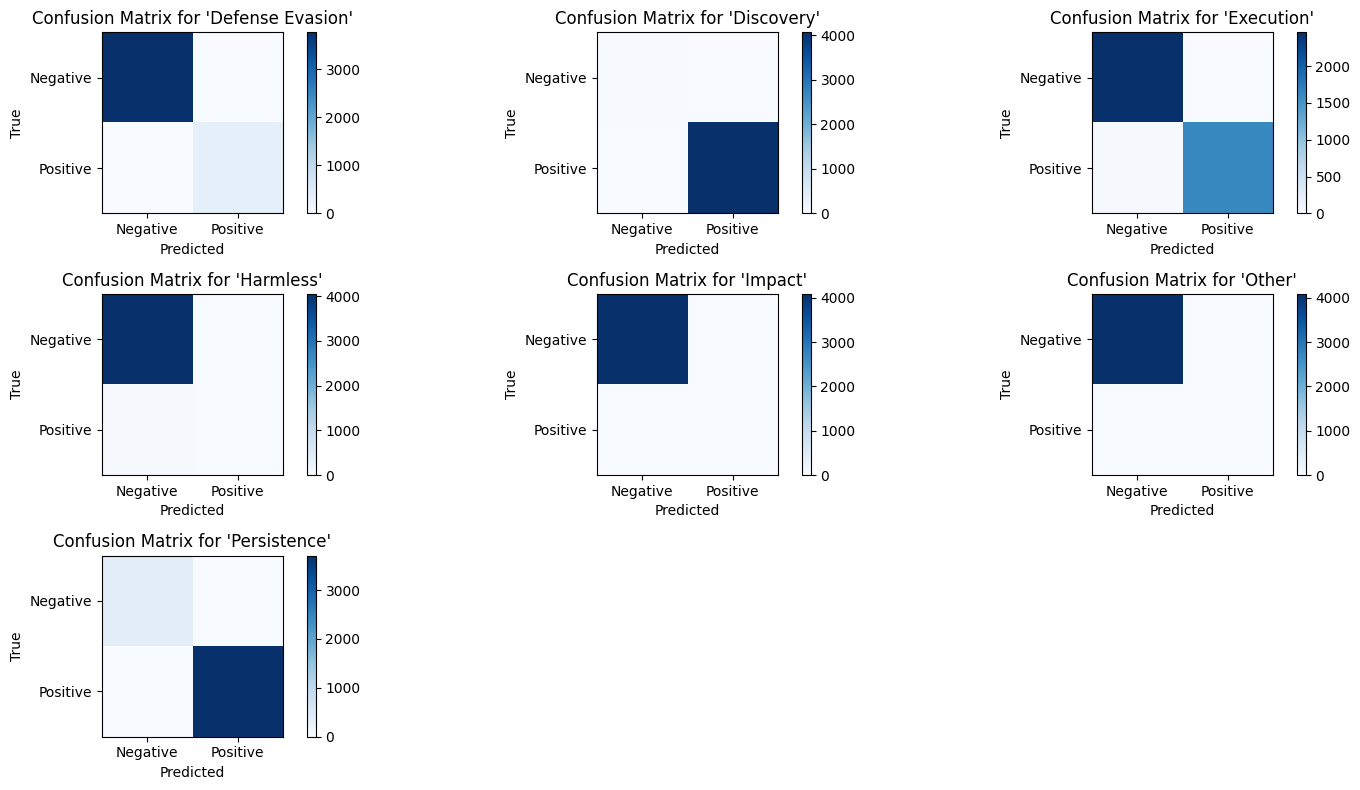

In [14]:
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f"Confusion Matrix for '{label}'")
    plt.imshow(confusion_rf_train[i], cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])
plt.tight_layout()
plt.show()

##### Validation Set

In [15]:
confusion_rf_test = multilabel_confusion_matrix(y_test_mlb, y_test_predictions)

for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for '{label}':")
    print(confusion_rf_test[i], "\n")   

Confusion Matrix for 'Defense Evasion':
[[1611    2]
 [   6  137]] 

Confusion Matrix for 'Discovery':
[[  11    0]
 [   4 1741]] 

Confusion Matrix for 'Execution':
[[1054    1]
 [  10  691]] 

Confusion Matrix for 'Harmless':
[[1733    2]
 [  18    3]] 

Confusion Matrix for 'Impact':
[[1749    2]
 [   3    2]] 

Confusion Matrix for 'Other':
[[1751    0]
 [   2    3]] 

Confusion Matrix for 'Persistence':
[[ 169    1]
 [   2 1584]] 



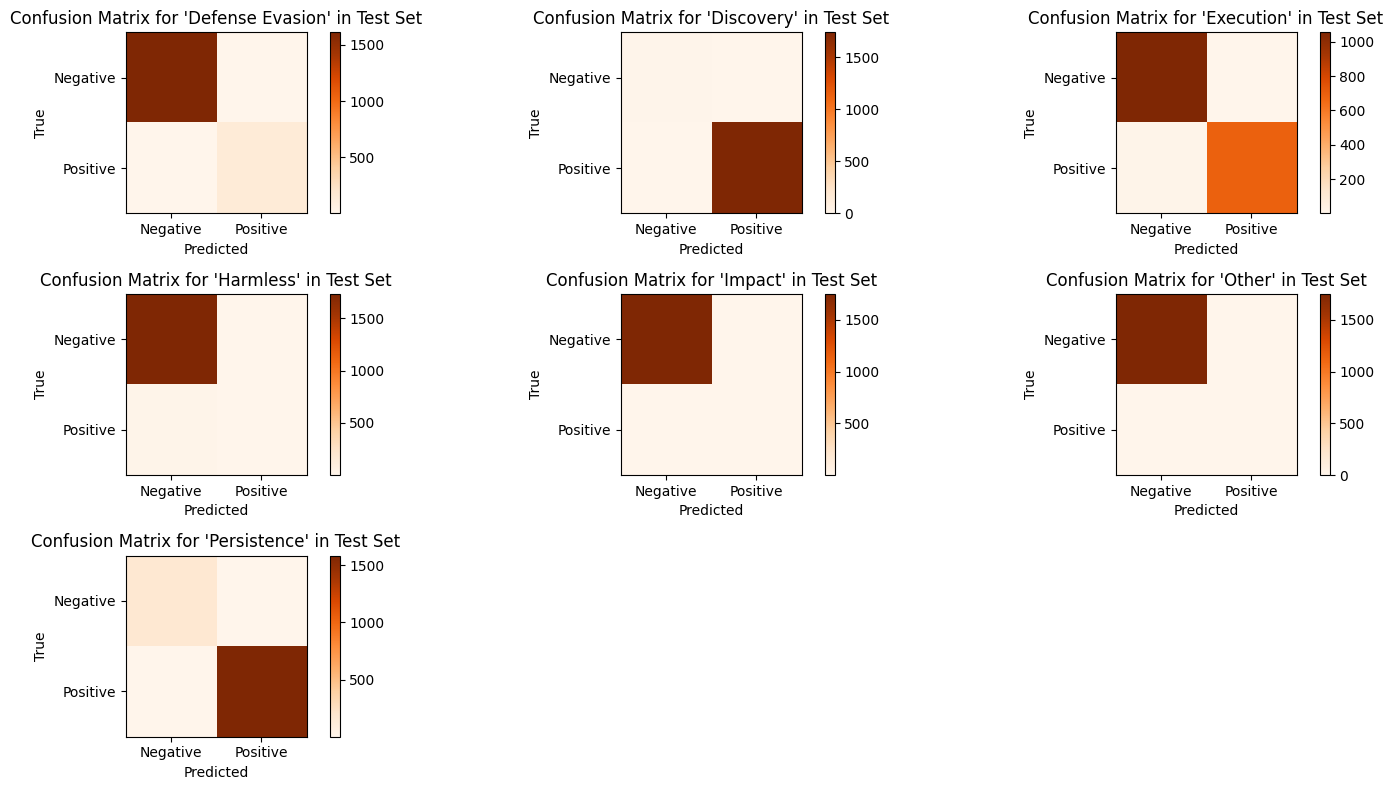

In [16]:
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f"Confusion Matrix for '{label}' in Test Set")
    plt.imshow(confusion_rf_test[i], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

plt.tight_layout()
plt.show()

<br>
<left><b><font size=4>K-Nearest Neighbors (KNN)<b><left>

<div style="text-align: justify">K-Nearest Neighbors (KNN) operates as a supervised learning classifier that relies on the concept of proximity to perform classifications or predictions for individual data points. Its fundamental principle is grounded in the notion that similar data points tend to cluster together. In the context of classification tasks, KNN assigns a class label to a data point by considering the majority vote of its nearest neighbors. Put simply, it selects the label that is most prevalent among the neighboring data points in close proximity to the one being evaluated.</div><br>

In [17]:
knn = KNeighborsClassifier()

st = time.time()
knn.fit(X_train, y_train_mlb)
et = time.time()

elapsed_time = et - st
print(f"Time to train the model: {elapsed_time} seconds")

Time to train the model: 0.00763249397277832 seconds


In [18]:
predictions_train = knn.predict(X_train) 
predictions_test = knn.predict(X_test)

In [19]:
accuracy = knn.score(X_train, y_train_mlb)
print(f"Accuracy of the k-NN model for the training set: {accuracy:.2f}")

accuracy = knn.score(X_test, y_test_mlb)
print(f"Accuracy of the k-NN model for the test set: {accuracy:.2f}")

Accuracy of the k-NN model for the training set: 0.98
Accuracy of the k-NN model for the test set: 0.97


<br>
<left><b><font size=3 >Classification Report<b><left>

##### Training Set

In [22]:
# Classification Report for training set
report_train_knn = classification_report(y_train_mlb, predictions_train, target_names=mlb.classes_, output_dict=True, zero_division=1)
df_report_train = pd.DataFrame(report_train_knn).transpose()
print("Classification Report for Training set:")
df_report_train

Classification Report for Training set:


,precision,recall,f1-score,support
Defense Evasion,0.987500,0.943284,0.964885,335.0
Discovery,0.998528,0.999754,0.999141,4070.0
Execution,0.998141,0.982916,0.990470,1639.0
Harmless,0.750000,0.125000,0.214286,48.0
Impact,1.000000,0.555556,0.714286,9.0
Other,0.750000,0.750000,0.750000,12.0
Persistence,0.995967,0.999730,0.997845,3705.0
micro avg,0.996616,0.990018,0.993306,9818.0
macro avg,0.925734,0.765177,0.804416,9818.0
weighted avg,0.995603,0.990018,0.991633,9818.0


##### Validation Set

In [23]:
# Classification Report for test set
report_test_knn = classification_report(y_test_mlb, predictions_test, target_names=mlb.classes_, output_dict=True, zero_division=1)
df_report_test_knn = pd.DataFrame(report_test_knn).transpose()
print("Classification Report for Test set:")
df_report_test_knn

Classification Report for Test set:


,precision,recall,f1-score,support
Defense Evasion,0.978417,0.951049,0.964539,143.0
Discovery,0.997708,0.997708,0.997708,1745.0
Execution,1.000000,0.982882,0.991367,701.0
Harmless,0.500000,0.047619,0.086957,21.0
Impact,0.500000,0.400000,0.444444,5.0
Other,0.666667,0.400000,0.500000,5.0
Persistence,0.997484,1.000000,0.998741,1586.0
micro avg,0.996405,0.988350,0.992361,4206.0
macro avg,0.805754,0.682751,0.711965,4206.0
weighted avg,0.993879,0.988350,0.990116,4206.0


<br>
<left><b><font size=3> Confusion Matrix <b><left>

The code presented below prints a series of confusion matrices for each class, displaying True-Positive (top-left), False-Negative (bottom-left), False-Positive (top-right), and True-Negative (bottom-right) counts.
- True Positives (TP): Predicted correctly as positive.
- False Positives (FP): Predicted as positive but actually negative.
- False Negatives (FN): Predicted as negative but actually positive.
- True Negatives (TN): Predicted correctly as negative.

Each value in the confusion matrix represents the count of instances falling into these categories for a specific label.

In [24]:
# Evaluate with a confusion matrix and classification report
confusion_knn_test = multilabel_confusion_matrix(y_test_mlb, predictions_test)
for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for {label}:")
    print(confusion_knn_test[i], "\n")

Confusion Matrix for Defense Evasion:
[[1610    3]
 [   7  136]] 

Confusion Matrix for Discovery:
[[   7    4]
 [   4 1741]] 

Confusion Matrix for Execution:
[[1055    0]
 [  12  689]] 

Confusion Matrix for Harmless:
[[1734    1]
 [  20    1]] 

Confusion Matrix for Impact:
[[1749    2]
 [   3    2]] 

Confusion Matrix for Other:
[[1750    1]
 [   3    2]] 

Confusion Matrix for Persistence:
[[ 166    4]
 [   0 1586]] 



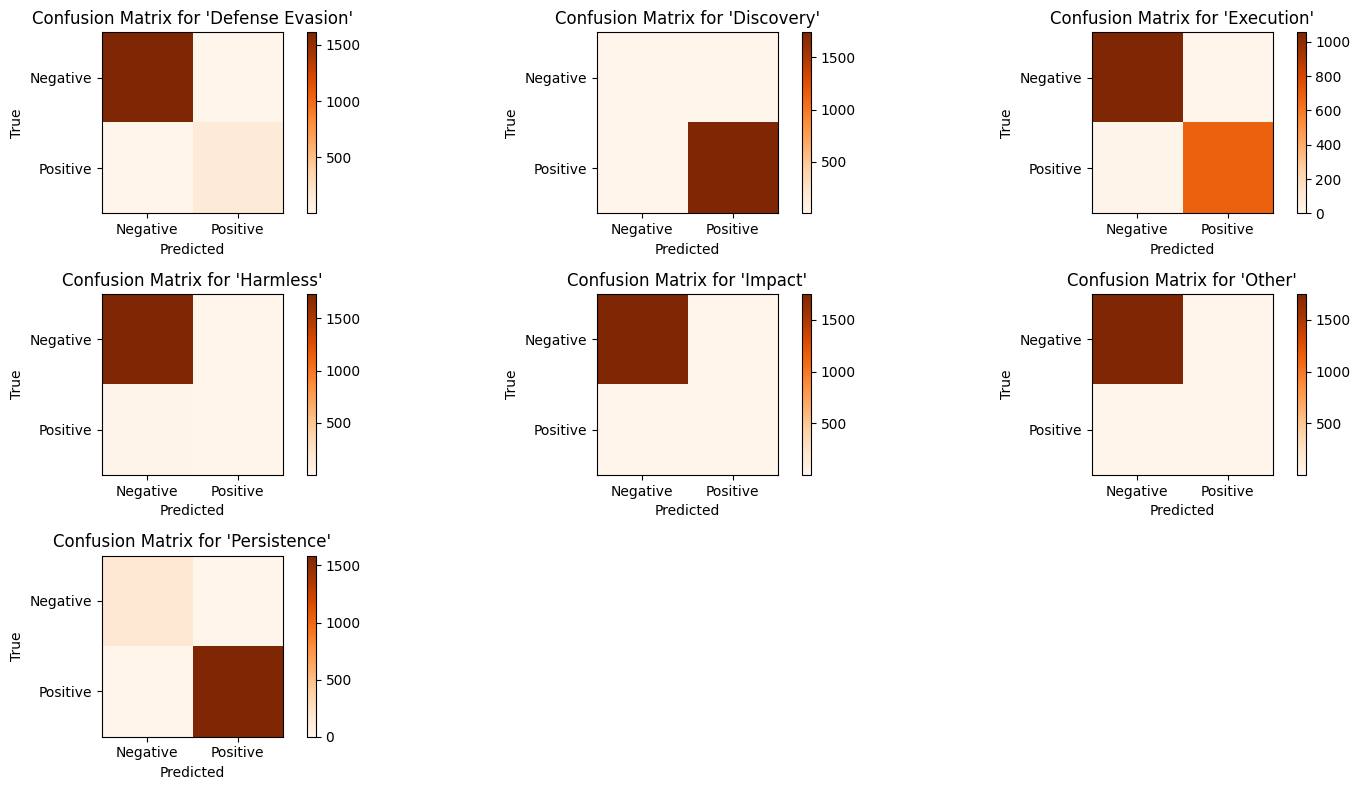

In [25]:
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f"Confusion Matrix for '{label}'")
    plt.imshow(confusion_knn_test[i], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

plt.tight_layout()
plt.show()

<div style="text-align: justify"> To know whether the model is underfitting or overfitting, we must first define these two terms. <br>
<div style="text-align: justify"><br><b>Underfitting</b> occurs when a model is too simple to capture the underlying patterns in the training data, resulting in poor performance even on the training set.  One indicator used to identify this modelling error is to look at the results; if both training and validation/testing performance are poor, the model is considered to be underfitted.</div><br>

<div style="text-align: justify"><b>Overfitting</b> occurs when a model not only learns the underlying patterns in the training data, but also captures noise and random fluctuations, causing it to perform poorly on new and unknown data. One indicator used to identify this modelling error is to look at the results, if the model performs well on training data but poorly on validation or test data, it is considered overfitted.</div><br>

<div style="text-align: justify">Once these two terms have been defined, it is possible to move on to the results obtained for both models. It is important to mention that, for both tests performed with the different classifiers, the default parameters were used.</div><br>
<div style="text-align: justify">For the <b>Random Forest (RF)</b> case, the default parameter implied the number of estimators equal to 100, and the tree depth was set to <i>'None'</i>. On the other hand, for the <b>K-Nearest Neighbor (KNN)</b> classifier, the number of estimators was set to 5, the leaf size to 30 and the type of distance calculation was <i>'Euclidean distance'</i> (p=2), all default parameters of the classifier.</div><br>
    
<b> Random Forest (RF)</b>
<div style="text-align: justify"> In the classification report of the training and test sets, for most of the classes, accuracy, recall and F1 score are slightly lower in the test set compared to the training set. This was expected, as models tend to generalise slightly worse with unseen data. However, the drop in performance is not significant, which indicates that the model still performs well on the test set. Furthermore, the accuracy obtained for the training set was 99%, while 98% for the test set.<br><br>
    
<div style="text-align: justify">As can be seen in the validation set report, the model was not able to correctly classify instances of the <i>'Impact'</i> class, performing very poorly (0%) on all precision, recall and F1 score metrics. This result could be due to the default parameters set to train the model.  Tree depth is one of the most important parameter for tuning the model, as it sets the stop condition that limits the number of splits or levels deep a decision tree can go.</div><br>

<div style="text-align: justify">To enhance the classifier results, it is necessary to adjust the maximum depth of the decision trees when performing hyperparameter fitting for a random forest model. The <i>'weighted avg'</i> metric also showed a decrease in performance on the test set, indicating that the model does not perform as well on the test set across all classes, considering the distribution of classes. Overall, the performance metrics on the test set remain high, indicating that the overfitting is not critical. </div><br>

<b> K-Nearest Neighbor (KNN)</b>

<div style="text-align: justify">On the other hand, the classification report obtained for the KNN classifier showed a small difference between the training set and the validation set, for the test set the values obtained for each of the metrics; accuracy, recall, f1-score, were slightly lower compared to the results obtained for the training set.</div><br>

<div style="text-align: justify"> For the <i>'Impact'</i> class, the metrics derived in the training set were significantly lower compared to the validation set, for all metrics. This improvement in the accuracy, recall and f1-score parameters for the <i>'Impact'</i> class in the test set indicates that the model's predictions for this class are more accurate and reliable when evaluated with new, unseen data.  Producing a recall of 50%, which means, that the model only correctly predicted this class for 50% of the evaluated intents. </div><br>

<div style="text-align: justify">The difference obtained in this class for the training and validation sets suggests that the model did not sufficiently fit the <i>'Impact'</i> class during training, and then after the selection of the nearest neighbour from the test set, the model adjusted its predictions to better capture the features of the <i>'Impact'</i> class. However, it is important to note that the KNN classifier does not fit the data, it does not learn from the model, it only calculates the distance to the nearest points and selects the class according to the majority result of the nearest neighbours.</div><br>

<div style="text-align: justify"> In general, the observed results do not indicate underfitting or overfitting, in fact, the average accuracy obtained in the classification report was 99%, matching with the obtained in the calculated accuracy score (98% for both sets). The high values of the <i>'micro-average'</i> in both sets suggest a good overall performance of the model. While the <i>'macro-average'</i> values are higher only in the test set, indicating that the model performs better after calculating the Euclidean distance of each point.</div><br>

**2.3 Tune the hyper-parameters of the models through cross-validation. How do performance vary?**

#### Grid Search Technique

<div style="text-align: justify">Hyperparameters are settings that control the learning process of machine learning models. While the parameters are learned during the training process, the hyperparameters are set before the training starts. Therefore, in order to find the parameters that best fit the performance of the model, the GridSearch technique was applied. This technique applies all possible combinations of hyperparameters, resulting in a set of parameters that will improve the performance of the model.</div>

#### Random Forest

In [26]:
# Create the parameter grid based on the results of random search 
params = {'n_estimators': [70, 100, 150], 'max_depth': [5, 10, None] } 

# Instantiate the grid search model
gs_rf = GridSearchCV(rf, param_grid = params, scoring='f1_macro', cv = 5, verbose = 1) 
# scoring='accuracy'
# cv: that's the number of fold for the cross-validation
# verbose: specifies the verbosity level of the GridSearchCV object. 

# Training the model
st = time.time()
gs_rf.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Time to train the model: {elapsed_time} seconds")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _w

Time to train the model: 24.120699405670166 seconds


In [27]:
best_params_rf = gs_rf.best_params_
print(f"The best combination of parameters the Grid Search has found is: {best_params_rf}")
print(f"Best F1-Score: {gs_rf.best_score_:.2f}")

The best combination of parameters the Grid Search has found is: {'max_depth': 10, 'n_estimators': 100}
Best F1-Score: 0.75


#### Ask to the prof which graph we should use -------------------------------------------------------------------------

In [ ]:
# Bar plot

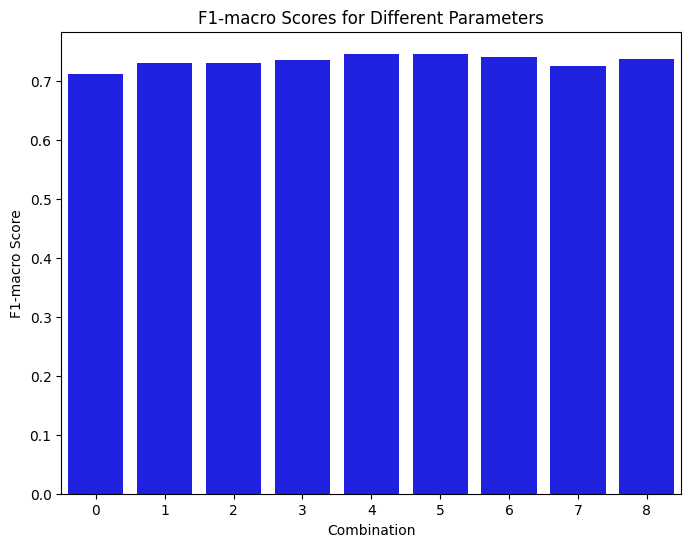

In [28]:
# Let's print the f1 macro reached for each combination
y = gs_rf.cv_results_["mean_test_score"].tolist()
x = [i for i in range (1, len(y)+1)]
mean_test_score_df = pd.DataFrame()
mean_test_score_df["f1_macro"] = y

plt.figure(figsize=(8, 6))
sns.barplot(x = mean_test_score_df.index, y = "f1_macro", data = mean_test_score_df, color='blue')

# Add a title and labels to the plot
plt.title('F1-macro Scores for Different Parameters')
plt.xlabel('Combination')
plt.ylabel('F1-macro Score')
plt.show()

In [ ]:
# Heatmap plot

In [29]:
results_rf = pd.DataFrame(gs_rf.cv_results_)
results_rf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.350736,0.083475,0.040784,0.009559,5,70,"{'max_depth': 5, 'n_estimators': 70}",0.749242,0.681560,0.728307,0.709727,0.693396,0.712447,0.024206,9
1,0.371683,0.008819,0.066393,0.035950,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.749242,0.681521,0.799736,0.709727,0.713476,0.730740,0.040657,6
2,0.587442,0.066146,0.065861,0.003138,5,150,"{'max_depth': 5, 'n_estimators': 150}",0.749242,0.681657,0.799423,0.709824,0.713476,0.730724,0.040508,7
3,0.303781,0.017099,0.037836,0.006043,10,70,"{'max_depth': 10, 'n_estimators': 70}",0.747228,0.681345,0.814711,0.711206,0.724579,0.735814,0.044841,5
4,0.424208,0.021379,0.069352,0.037399,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.747228,0.736937,0.814711,0.710968,0.724435,0.746856,0.036037,1
5,0.674826,0.118666,0.069130,0.003604,10,150,"{'max_depth': 10, 'n_estimators': 150}",0.747228,0.736657,0.814494,0.710731,0.724435,0.746709,0.036019,2
6,0.391609,0.078278,0.046756,0.015894,None,70,"{'max_depth': None, 'n_estimators': 70}",0.699522,0.736840,0.814494,0.710968,0.743421,0.741049,0.040117,3
7,0.473574,0.068418,0.049067,0.001826,None,100,"{'max_depth': None, 'n_estimators': 100}",0.699609,0.679514,0.814711,0.710968,0.725723,0.726105,0.046804,8
8,0.630924,0.016684,0.068325,0.001359,None,150,"{'max_depth': None, 'n_estimators': 150}",0.699609,0.736744,0.815723,0.710968,0.724579,0.737525,0.041051,4


In [30]:
# We create a pivot table 
scores_rf = results_rf.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
scores_rf

param_n_estimators,70,100,150
param_max_depth,,,
NaN,0.741049,0.726105,0.737525
5.0,0.712447,0.730740,0.730724
10.0,0.735814,0.746856,0.746709


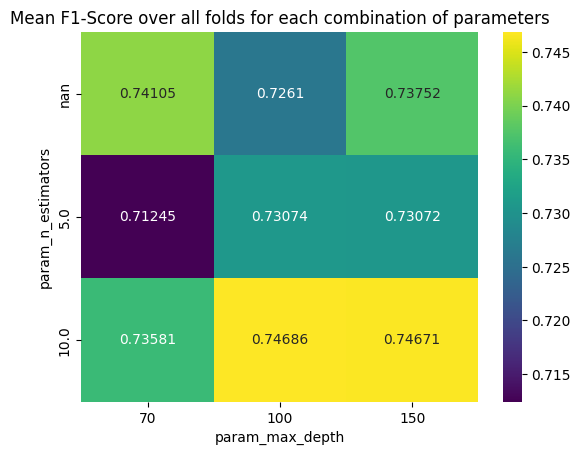

In [31]:
sns.heatmap(scores_rf, annot=True, cmap='viridis', fmt='.5g')
plt.xlabel('param_max_depth')
plt.ylabel('param_n_estimators')
plt.title('Mean F1-Score over all folds for each combination of parameters')
plt.show()

#### K-Nearest Neighbor

In [32]:
params = {'n_neighbors': [5, 10, 20], 'leaf_size': [10, 70, 100]}
grid_search_knn = GridSearchCV(knn, params, scoring='f1_macro', cv = 5, verbose=1)
# scoring = 'accuracy'

st = time.time()
grid_search_knn.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Time to train the model: {elapsed_time} seconds")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _w

Time to train the model: 16.44329285621643 seconds


In [33]:
best_params_knn = grid_search_knn.best_params_
print(f"The best combination of parameters the Grid Search has found is: {best_params_knn}")
print("Best F1-Score: {:.2f}".format(grid_search_knn.best_score_))

The best combination of parameters the Grid Search has found is: {'leaf_size': 10, 'n_neighbors': 5}
Best F1-Score: 0.69


#### Aks to the prof which graph we should use --------------------------------------------------------------------------

In [ ]:
#Bar plot

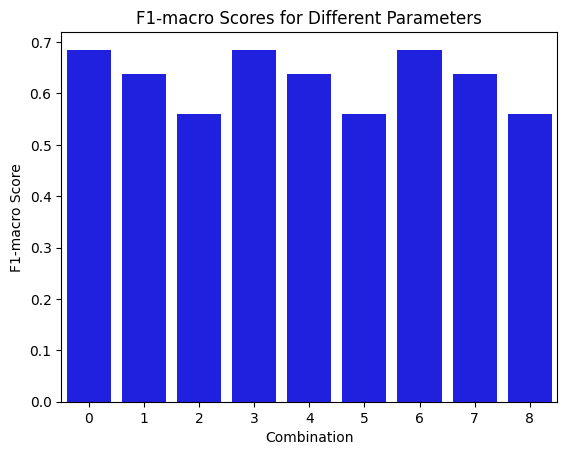

In [34]:
# Let's print the f1 macro reached for each combination
y = grid_search_knn.cv_results_["mean_test_score"].tolist()
x = [i for i in range (1, len(y)+1)]
mean_test_score_df = pd.DataFrame()
mean_test_score_df["f1_macro"] = y
#print(mean_test_score_df)

sns.barplot(x = mean_test_score_df.index, y = "f1_macro", data = mean_test_score_df, color='blue')
# Add a title and labels to the plot
plt.title('F1-macro Scores for Different Parameters')
plt.xlabel('Combination')
plt.ylabel('F1-macro Score')

# Display the plot
plt.show()

In [ ]:
# Heatmap plot

In [35]:
results_knn = pd.DataFrame(grid_search_knn.cv_results_)
results_knn

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_leaf_size,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004403,0.004482,0.371437,0.065503,10,5,"{'leaf_size': 10, 'n_neighbors': 5}",0.563981,0.723867,0.775842,0.708476,0.653318,0.685097,0.072060,1
1,0.003885,0.003673,0.295639,0.012063,10,10,"{'leaf_size': 10, 'n_neighbors': 10}",0.564207,0.561251,0.703122,0.707516,0.652921,0.637803,0.064236,4
2,0.003457,0.002572,0.295265,0.008535,10,20,"{'leaf_size': 10, 'n_neighbors': 20}",0.562762,0.558545,0.556622,0.561875,0.556325,0.559226,0.002653,7
3,0.003674,0.002095,0.368871,0.114538,70,5,"{'leaf_size': 70, 'n_neighbors': 5}",0.563981,0.723867,0.775842,0.708476,0.653318,0.685097,0.072060,1
4,0.002332,0.001317,0.373366,0.050264,70,10,"{'leaf_size': 70, 'n_neighbors': 10}",0.564207,0.561251,0.703122,0.707516,0.652921,0.637803,0.064236,4
5,0.003375,0.002023,0.373696,0.041440,70,20,"{'leaf_size': 70, 'n_neighbors': 20}",0.562762,0.558545,0.556622,0.561875,0.556325,0.559226,0.002653,7
6,0.003032,0.003347,0.342872,0.033979,100,5,"{'leaf_size': 100, 'n_neighbors': 5}",0.563981,0.723867,0.775842,0.708476,0.653318,0.685097,0.072060,1
7,0.006341,0.004437,0.355888,0.035036,100,10,"{'leaf_size': 100, 'n_neighbors': 10}",0.564207,0.561251,0.703122,0.707516,0.652921,0.637803,0.064236,4
8,0.008020,0.001995,0.463154,0.079546,100,20,"{'leaf_size': 100, 'n_neighbors': 20}",0.562762,0.558545,0.556622,0.561875,0.556325,0.559226,0.002653,7


In [36]:
# We create a pivot table before create the heatmap
scores_knn = results_knn.pivot(index='param_leaf_size', columns='param_n_neighbors', values='mean_test_score')
scores_knn

param_n_neighbors,5,10,20
param_leaf_size,,,
10,0.685097,0.637803,0.559226
70,0.685097,0.637803,0.559226
100,0.685097,0.637803,0.559226


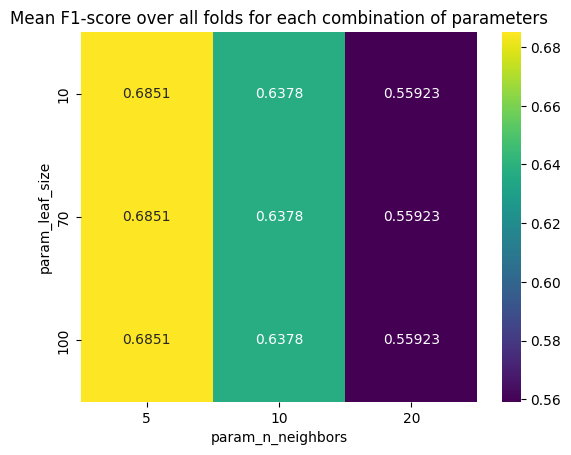

In [37]:
sns.heatmap(scores_knn, annot=True, cmap='viridis', fmt='.5g')
plt.xlabel('param_n_neighbors')
plt.ylabel('param_leaf_size')
plt.title('Mean F1-score over all folds for each combination of parameters')
plt.show()

**2.4. Comments on the results for each on the intents.**

<div style="text-align: justify">The aim of this analysis is to assess the predictive capability of two models in classifying attack labels. The models will be evaluated based on the hyperparameters identified previously.</div>

##### Evaluation of Random Forest with tuned parameters

In [38]:
# Random Forest with the hyperparameters
model_rf_tunned = RandomForestClassifier(n_estimators = 50, max_depth = 10000)

st = time.time()
# Trainning the model
model_rf_tunned.fit(X_train, y_train_mlb)
et = time.time()
# get the execution time
elapsed_time = et - st
print(f'Time to train the model:', elapsed_time,'seconds','\n')

# Predictions on test set
y_test_pred_tune = rf.predict(X_test)

# Evaluate the model's performance on the test data
accuracy = model_rf_tunned.score(X_test, y_test_mlb)
print(f"Accuracy of the 'Random Forest' model for test set: {accuracy:.2f}",'\n')

# Evaluate performance on test set
report_test_tune = classification_report(y_test_mlb, y_test_pred_tune, target_names=mlb.classes_, output_dict=True,
                                         zero_division=1)
df_report_test_tune = pd.DataFrame(report_test_tune).transpose()
print(f'         Classification Report Trainning Set', '\n')
print(df_report_test_tune)

Time to train the model: 0.3281538486480713 seconds 

Accuracy of the 'Random Forest' model for test set: 0.98 

         Classification Report Trainning Set 

                 precision    recall  f1-score  support
Defense Evasion   0.985612  0.958042  0.971631    143.0
Discovery         1.000000  0.997708  0.998853   1745.0
Execution         0.998555  0.985735  0.992103    701.0
Harmless          0.600000  0.142857  0.230769     21.0
Impact            0.500000  0.400000  0.444444      5.0
Other             1.000000  0.600000  0.750000      5.0
Persistence       0.999369  0.998739  0.999054   1586.0
micro avg         0.998081  0.989301  0.993672   4206.0
macro avg         0.869077  0.726154  0.769551   4206.0
weighted avg      0.996441  0.989301  0.992088   4206.0
samples avg       0.997675  0.989132  0.992269   4206.0


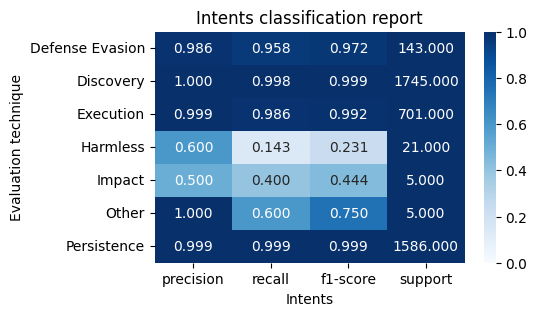

In [39]:
# Compute the heatmap of the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(df_report_test_tune.loc["Defense Evasion" : "Persistence"], cmap='Blues', annot=True, vmin=.0, vmax=1,fmt='.3f')
plt.xlabel('Intents')
plt.ylabel('Evaluation technique')
plt.title('Intents classification report')
plt.show()

##### Evalutaing of K-Nearest Neighbors with tuned parameters

In [40]:
# Create the k-NN model
knn_tune = KNeighborsClassifier(leaf_size=10, n_neighbors=5)

# Train the model on the training data
t = time.time()
knn_tune.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Time to train the model: {elapsed_time} seconds")

# Generate predictions on the test set
predictions_knn_tune = knn.predict(X_test)

# Evaluate the model's performance on the test data
accuracy_knn_tune = knn.score(X_test, y_test_mlb)
print(f"Accuracy of the k-NN model: {accuracy_knn_tune:.2f}",'\n')

report_knn_tune = classification_report(y_test_mlb, predictions_knn_tune, target_names = mlb.classes_, output_dict=True,
                                       zero_division=1)
df_report_knn_tune = pd.DataFrame(report_knn_tune).transpose()
print("              Classification Report for KNN",'\n')
print(df_report_knn_tune)

Time to train the model: 18.140897274017334 seconds
Accuracy of the k-NN model: 0.97 

              Classification Report for KNN 

                 precision    recall  f1-score  support
Defense Evasion   0.978417  0.951049  0.964539    143.0
Discovery         0.997708  0.997708  0.997708   1745.0
Execution         1.000000  0.982882  0.991367    701.0
Harmless          0.500000  0.047619  0.086957     21.0
Impact            0.500000  0.400000  0.444444      5.0
Other             0.666667  0.400000  0.500000      5.0
Persistence       0.997484  1.000000  0.998741   1586.0
micro avg         0.996405  0.988350  0.992361   4206.0
macro avg         0.805754  0.682751  0.711965   4206.0
weighted avg      0.993879  0.988350  0.990116   4206.0
samples avg       0.995330  0.988326  0.993975   4206.0


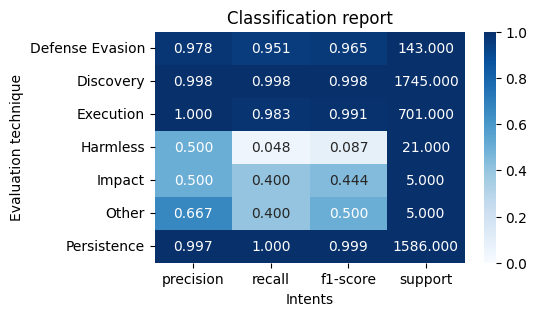

In [41]:
# Compute the heatmap of the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(df_report_knn_tune.loc["Defense Evasion" : "Persistence"], cmap='Blues', annot=True, vmin=.0, vmax=1,fmt='.3f')
plt.xlabel('Intents')
plt.ylabel('Evaluation technique')
plt.title('Classification report')
plt.show()

Need to write how the hyperparameter tunning improves the result; especially in the intent Impact, for both models... I'll do it later.

**2.5 Explore the possible features: try combining features differently, e.g., does tf-idf improve or worsen performance? Think about the problem and summarize the ways you have tried (even those that did not work).**

<div style="text-align: justify"><b>First Attempt</b></div><br>

<div style="text-align: justify">For the first attempt, 33 features were used for the training set. The classifiers selected to perform the predictions were 'Random Forest' and 'K-Nearest Neighbor' with both models using the default parameters. In the performance evaluation, an accuracy of 98% was obtained for both models in the validation set.  While in the training set it reached 99% for RF and 98% for KNN. The decrease in accuracy achieved by RF in the validation set suggests a slight overfitting, however, it is a tolerable value that assumes that the model still performs well on the test set.</div><br>

<div style="text-align: justify">According to the classification report, for almost all attempts the values of precision, recall and f1-scores reached high percentages, around 98.9%.  Except for the 'Impact' and 'Harmless' intents when applying RF as a model, the results obtained for these classes were quite lower compared to those obtained for the other classes, both in the training set and in the validation set, where 0% was obtained in each metric. The model presented a very poor performance when trying to classify these two classes.</div><br>

<div style="text-align: justify">As for tuning techniques, K-fold cross-correlation and Grid Search were applied to see if the results obtained previously could be improved. However, when looking at the results obtained with 5 folds, the performance decreased considerably reaching an average of 77% accuracy. Suggests that the model may be in overfitting. </div><br>

<div style="text-align: justify">Therefore, for the next attempt we consider a reduction of the dimensionality of the data set to improve generalization.</div><br>

<div style="text-align: justify"><b>Second attempt</b></div><br>
<div style="text-align: justify">For the second attempt, the number of features was reduced to only 12 for the training set.  The classifiers used in the previous attempt, RF and KNN, were kept for this evaluation with both using their default parameters. The results obtained in the performance evaluation, the accuracy did not change from the previous attempt, reaching 98% for the RF case and 98% for the KNN for both the training and validation sets, indicating that the models continue to make good predictions for the classes.<br>
<br>
<div style="text-align: justify">If we take a look at the classification report for almost all attempts, the values for accuracy, recall and f1-scores reached high percentages, around 98%. Nevertheless, the performance of the 'Impact' class was very poor in both models for the classification obtained in the validation data, with 0% for every metric (precision, recall and f1-score), indicating that the number of features selected to train both models was not sufficient to be able to correctly classify this class.<br><br>
<div style="text-align: justify">In both training and validation reports, the F1 score obtained for the classes "Impact" and "Harmless" was very low compared to the other classes. It seems that for both models, these two classes are the most difficult to classify correctly. This could be due to the fact that, the number of data selected during the splitting of the training set did not cover enough samples of these two classes, as they are the least sampled attempts of the whole dataset. </div><br>

<div style="text-align: justify">After conducting multiple tests and adjusting the number of features in the training set, the results showed similar levels of accuracy. However, upon further analysis of the classification report parameters, it was found that the highest metrics for accuracy, recall, and F1-score were achieved with a number of features greater than 22. The F1-score parameter indicated that the models performed better in classifying samples belonging to the 'Impact' and 'Harmless' classes, which were more difficult to detect in almost all the tests. </div><br>